#Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Activation
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load data

In [2]:
def load_dataframe(subset_number):
    turbo_train= pd.read_csv(f"/content/drive/MyDrive/NASAturbofan/train_FD00{subset_number}.txt", sep='\s+',header=None, index_col=False)
    turbo_test = pd.read_csv(f'/content/drive/MyDrive/NASAturbofan/test_FD00{subset_number}.txt', sep='\s+',header=None, index_col=False)
    y_RUL = pd.read_csv(f'/content/drive/MyDrive/NASAturbofan/RUL_FD00{subset_number}.txt', sep='\s+',header=None, index_col=False)
    return turbo_train, turbo_test, y_RUL

In [3]:
turbo_train_1, turbo_test_1, y_RUL_1 = load_dataframe(1)
turbo_train_2, turbo_test_2, y_RUL_2 = load_dataframe(2)
turbo_train_3, turbo_test_3, y_RUL_3 = load_dataframe(3)
turbo_train_4, turbo_test_4, y_RUL_4 = load_dataframe(4)

In [4]:
turbo_train_1

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [5]:
def count_engines(turbofan):
  unique_engines = turbofan[0].unique()
  num_engines = len(unique_engines)
  return num_engines

In [6]:
nr_train_1=count_engines(turbo_train_1)
nr_train_2=count_engines(turbo_train_2)
nr_train_3=count_engines(turbo_train_3)
nr_train_4=count_engines(turbo_train_4)
nr_test_1=count_engines(turbo_test_1)
nr_test_2=count_engines(turbo_test_2)
nr_test_3=count_engines(turbo_test_3)
nr_test_4=count_engines(turbo_test_4)

In [7]:
nr_train_1

100

In [8]:
def original_RUL_train(turbo_train):
  turbo_train.sort_values(by=[0, 1], inplace=True)
  turbo_train['RUL'] = turbo_train.groupby(0).cumcount(ascending=False)
  return turbo_train

In [9]:
turbo_train_1=original_RUL_train(turbo_train_1)
turbo_train_2=original_RUL_train(turbo_train_2)
turbo_train_3=original_RUL_train(turbo_train_3)
turbo_train_4=original_RUL_train(turbo_train_4)

In [10]:
turbo_train_1

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [11]:
def original_RUL_test(turbo_test, y_RUL):
  y_RUL_series=y_RUL[0]
  turbo_test.sort_values(by=[0, 1], inplace=True)
  adjusted_engine_numbers = turbo_test[0].values - 1
  turbo_test['RUL'] = turbo_test.groupby(0).cumcount(ascending=False) + y_RUL_series.iloc[adjusted_engine_numbers].values
  return turbo_test

In [ ]:
turbo_test_1=original_RUL_test(turbo_test_1, y_RUL_1)
turbo_test_2=original_RUL_test(turbo_test_2, y_RUL_2)
turbo_test_3=original_RUL_test(turbo_test_3, y_RUL_3)
turbo_test_4=original_RUL_test(turbo_test_4, y_RUL_4)

In [ ]:
def complete_dataframe(turbo_train, turbo_test):
  turbo_test_reset = turbo_test.reset_index(drop=True)
  last_engine = turbo_train[0].iloc[-1]
  turbo_test_reset[0] += last_engine
  turbofan = pd.concat([turbo_train, turbo_test_reset], ignore_index=True)
  return turbofan

In [ ]:
turbofan1=complete_dataframe(turbo_train_1, turbo_test_1)
turbofan2=complete_dataframe(turbo_train_2, turbo_test_2)
turbofan3=complete_dataframe(turbo_train_3, turbo_test_3)
turbofan4=complete_dataframe(turbo_train_4, turbo_test_4)

In [ ]:
turbofan1

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
33723,200,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
33724,200,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
33725,200,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [ ]:
def rename_columns(turbofan):
  new_columns = ['ENr', 'C', 'OP-1', 'OP-2', 'OP-3',
                 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi',
                 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf-dmd', 'PCNfR-dmd', 'W31', 'W32', 'RUL']
  turbofan.columns = new_columns
  return turbofan

In [ ]:
turbofan1=rename_columns(turbofan1)
turbofan2=rename_columns(turbofan2)
turbofan3=rename_columns(turbofan3)
turbofan4=rename_columns(turbofan4)

In [ ]:
turbofan1

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf-dmd,PCNfR-dmd,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
33723,200,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
33724,200,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
33725,200,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


#Correlation Analysis

In [ ]:
def compute_pearson(turbofan):
  correlation_matrix = abs(turbofan.corr(method='pearson'))*100
  target_column = 'RUL'
  correlation = correlation_matrix[target_column]
  return round(correlation, 3)

In [ ]:
p1=compute_pearson(turbofan1)
p2=compute_pearson(turbofan2)
p3=compute_pearson(turbofan3)
p4=compute_pearson(turbofan4)

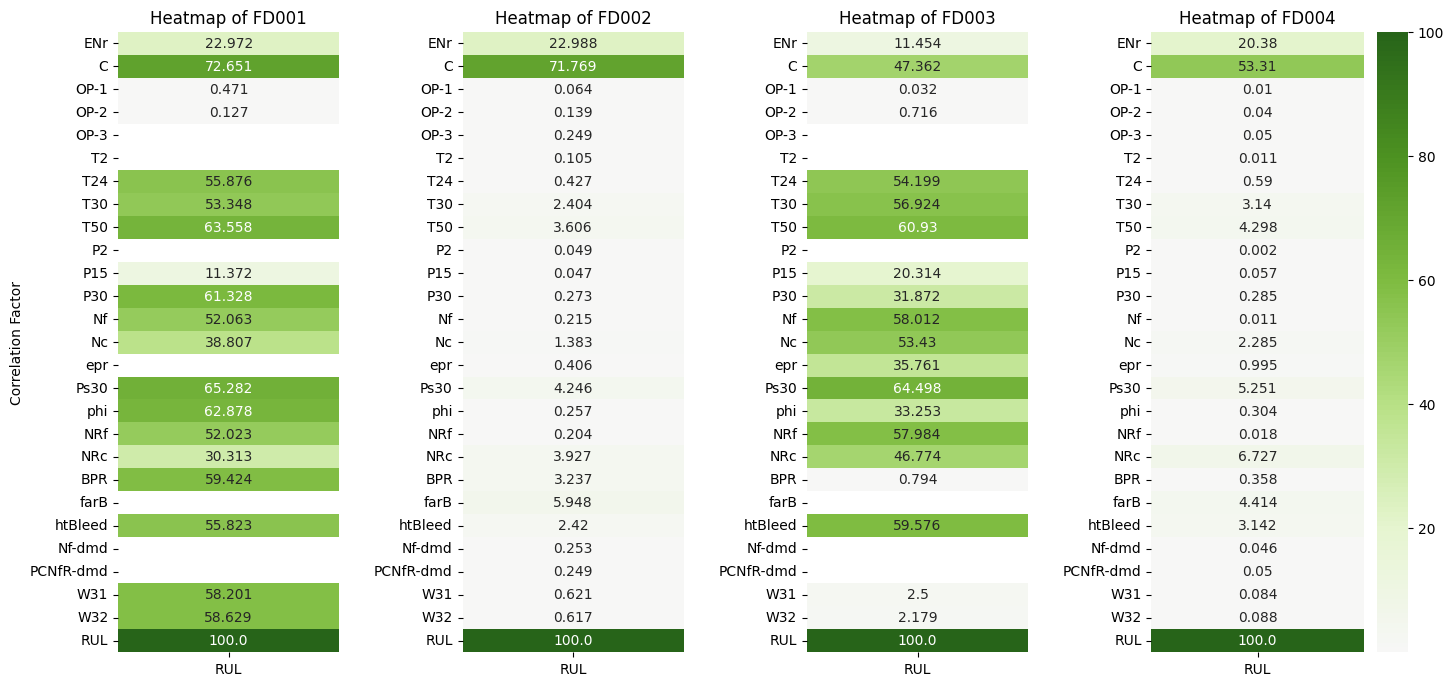

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 8), gridspec_kw={'width_ratios': [1, 1, 1, 1.2]})

sns.heatmap(p1.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[0], cbar=False)
axs[0].set_title('Heatmap of FD001')
axs[0].set_ylabel('Correlation Factor')

sns.heatmap(p2.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[1], cbar=False)
axs[1].set_title('Heatmap of FD002')

sns.heatmap(p3.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[2], cbar=False)
axs[2].set_title('Heatmap of FD003')

sns.heatmap(p4.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[3])
axs[3].set_title('Heatmap of FD004')

plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=2.5)

plt.show()

In [ ]:
columns_to_drop1 = ['T2', 'P2', 'P15', 'epr', 'farB', 'Nf-dmd', 'PCNfR-dmd']
columns_to_drop3 = ['T2', 'P2', 'epr', 'farB', 'Nf-dmd', 'PCNfR-dmd']

In [ ]:
turbofan1.drop(columns=columns_to_drop1, inplace=True)
turbofan3.drop(columns=columns_to_drop3, inplace=True)

In [ ]:
turbofan1

,ENr,C,OP-1,OP-2,OP-3,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,0.0049,0.0000,100.0,643.24,1599.45,1415.79,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974,24
33723,200,195,-0.0011,-0.0001,100.0,643.22,1595.69,1422.05,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771,23
33724,200,196,-0.0006,-0.0003,100.0,643.44,1593.15,1406.82,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051,22
33725,200,197,-0.0038,0.0001,100.0,643.26,1594.99,1419.36,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699,21


#Filtering

In [ ]:
def moving_median(turbofan, window_size, period):
    columns_to_filter = turbofan.columns.drop(['ENr', 'C', 'RUL', 'OP-1', 'OP-2', 'OP-3'])
    filtered_turbo = turbofan.copy()
    grouped = filtered_turbo.groupby('ENr')[columns_to_filter]
    filtered_turbo[columns_to_filter] = grouped.rolling(window=window_size, min_periods=period, axis=0).median().reset_index(drop=True)

    return filtered_turbo

In [ ]:
filtered_turbo1=moving_median(turbofan1, 5, 1)
filtered_turbo2=moving_median(turbofan2, 5, 1)
filtered_turbo3=moving_median(turbofan3, 5, 1)
filtered_turbo4=moving_median(turbofan4, 5, 1)

In [ ]:
filtered_turbo1

,ENr,C,OP-1,OP-2,OP-3,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,641.820,1589.700,1400.600,554.360,2388.06,9046.190,47.47,521.66,2388.020,8138.620,8.41950,392.0,39.060,23.41900,191
1,1,2,0.0019,-0.0003,100.0,641.985,1590.760,1401.870,554.055,2388.05,9045.130,47.48,521.97,2388.045,8135.055,8.42565,392.0,39.030,23.42130,190
2,1,3,-0.0043,0.0003,100.0,642.150,1589.700,1403.140,554.260,2388.06,9046.190,47.47,522.28,2388.030,8133.230,8.41950,392.0,39.000,23.41900,189
3,1,4,0.0007,0.0000,100.0,642.250,1588.845,1402.505,554.310,2388.07,9047.835,47.37,522.35,2388.050,8133.530,8.41865,392.0,38.975,23.39645,188
4,1,5,-0.0019,-0.0002,100.0,642.350,1587.990,1403.140,554.260,2388.06,9049.480,47.28,522.28,2388.040,8133.800,8.41950,392.0,38.950,23.40440,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,0.0049,0.0000,100.0,643.050,1598.180,1415.790,553.240,2388.05,9139.880,47.58,521.23,2388.070,8210.240,8.47150,395.0,38.740,23.22790,24
33723,200,195,-0.0011,-0.0001,100.0,643.100,1595.690,1415.790,553.220,2388.05,9140.680,47.60,521.05,2388.070,8210.850,8.45120,395.0,38.650,23.22790,23
33724,200,196,-0.0006,-0.0003,100.0,643.220,1595.690,1415.790,553.180,2388.05,9141.920,47.58,521.05,2388.050,8213.280,8.45120,395.0,38.630,23.21480,22
33725,200,197,-0.0038,0.0001,100.0,643.240,1595.600,1415.790,553.220,2388.07,9142.370,47.60,521.18,2388.050,8213.570,8.45690,395.0,38.630,23.26990,21


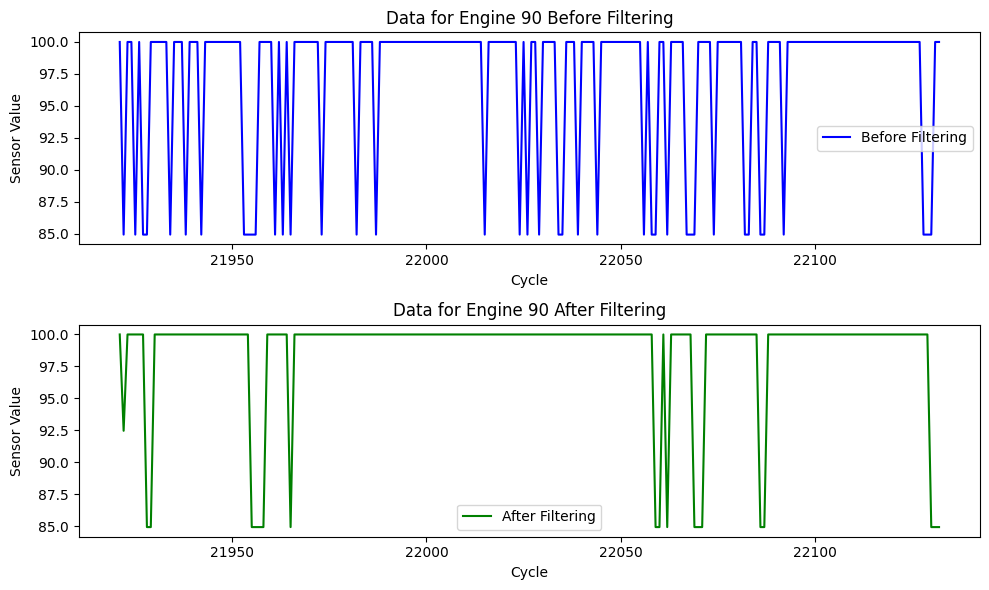

In [ ]:
def plot_data_before_and_after(turbofan, filtered_turbo, engine_number):
    engine_data_before = turbofan[turbofan['ENr'] == engine_number]
    engine_data_after = filtered_turbo[filtered_turbo['ENr'] == engine_number]

    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(engine_data_before['PCNfR-dmd'], label='Before Filtering', color='blue')
    plt.title(f'Data for Engine {engine_number} Before Filtering')
    plt.xlabel('Cycle')
    plt.ylabel('Sensor Value')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(engine_data_after['PCNfR-dmd'], label='After Filtering', color='green')
    plt.title(f'Data for Engine {engine_number} After Filtering')
    plt.xlabel('Cycle')
    plt.ylabel('Sensor Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

engine_number = 90
plot_data_before_and_after(turbofan4, filtered_turbo4, engine_number)

#Normalization

In [ ]:
def z_score(turbofan):
  scaler = StandardScaler()
  normalized_turbo = turbofan.copy()
  columns_to_normalize = turbofan.columns.drop(['ENr', 'C', 'RUL'])
  normalized_turbo[columns_to_normalize] = scaler.fit_transform(turbofan[columns_to_normalize])
  return normalized_turbo

In [ ]:
normalized_turbo1=z_score(filtered_turbo1)
normalized_turbo2=z_score(filtered_turbo2)
normalized_turbo3=z_score(filtered_turbo3)
normalized_turbo4=z_score(filtered_turbo4)

In [ ]:
normalized_turbo1

,ENr,C,OP-1,OP-2,OP-3,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,-0.314711,-1.373690,0.0,-1.960981,0.051092,-0.860848,1.104758,-0.413888,-0.902209,-0.072214,0.157062,-1.062438,-0.196619,-0.509848,-0.755387,1.452095,1.253265,191
1,1,2,0.870755,-1.032895,0.0,-1.539943,0.278279,-0.692696,0.695026,-0.578089,-0.961536,-0.028486,0.650019,-0.653695,-0.426444,-0.307572,-0.755387,1.244488,1.279766,190
2,1,3,-1.956125,1.011877,0.0,-1.118905,0.051092,-0.524544,0.970419,-0.413888,-0.902209,-0.072214,1.142976,-0.898941,-0.544096,-0.509848,-0.755387,1.036882,1.253265,189
3,1,4,0.323617,-0.010509,0.0,-0.863730,-0.132158,-0.608620,1.037588,-0.249687,-0.810141,-0.509501,1.254289,-0.571947,-0.524756,-0.537805,-0.755387,0.863876,0.993444,188
4,1,5,-0.861849,-0.692099,0.0,-0.608555,-0.315408,-0.524544,0.970419,-0.413888,-0.718073,-0.903059,1.142976,-0.735444,-0.507350,-0.509848,-0.755387,0.690871,1.085044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,2.238601,-0.010509,0.0,1.177669,1.868590,1.150357,-0.399832,-0.578089,4.341474,0.408801,-0.526717,-0.244952,4.420501,1.200454,1.689970,-0.762375,-0.948586,24
33723,200,195,-0.497090,-0.351304,0.0,1.305256,1.334915,1.150357,-0.426700,-0.578089,4.386248,0.496258,-0.812950,-0.244952,4.459826,0.532779,1.689970,-1.385195,-0.948586,23
33724,200,196,-0.269116,-1.032895,0.0,1.611466,1.334915,1.150357,-0.480435,-0.578089,4.455649,0.408801,-0.812950,-0.571947,4.616481,0.532779,1.689970,-1.523599,-1.099524,22
33725,200,197,-1.728151,0.330287,0.0,1.662501,1.315625,1.150357,-0.426700,-0.249687,4.480835,0.496258,-0.606226,-0.571947,4.635176,0.720254,1.689970,-1.523599,-0.464663,21


#Damage modeling

In [ ]:
def split_dataframe(normalized_turbofan, nr_train):
  turbo_RUL_train = normalized_turbofan[(normalized_turbofan['ENr'] <= nr_train)]
  turbo_RUL_test = normalized_turbofan[(normalized_turbofan['ENr'] > nr_train)]
  return turbo_RUL_train, turbo_RUL_test

In [ ]:
turbo1_train, turbo1_test=split_dataframe(normalized_turbo1, nr_train_1)
turbo2_train, turbo2_test=split_dataframe(normalized_turbo2, nr_train_2)
turbo3_train, turbo3_test=split_dataframe(normalized_turbo3, nr_train_3)
turbo4_train, turbo4_test=split_dataframe(normalized_turbo4, nr_train_4)

In [ ]:
turbo2_train

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf-dmd,PCNfR-dmd,W31,W32,RUL
0,1,1,0.745887,0.864365,0.417857,-1.042505,-0.691457,-0.751917,-0.633325,-0.900642,...,0.169413,-0.774976,0.266950,-0.503253,-0.654026,-0.377212,0.175192,-0.648853,-0.656427,148
1,1,2,1.220153,0.866942,0.417857,-1.155460,-0.786515,-0.788770,-0.702782,-1.227697,...,0.168914,-0.501478,0.307574,-0.503253,-0.758272,-0.446704,0.175192,-0.962836,-0.964210,147
2,1,3,0.068389,0.161386,-2.393163,-1.042505,-0.881573,-0.825623,-0.772239,-0.900642,...,0.168414,-0.774976,0.348197,-0.503253,-0.862519,-0.516196,0.175192,-0.743339,-0.689088,146
3,1,4,1.220797,0.869520,0.417857,-1.155460,-0.888413,-0.820085,-0.768599,-1.227697,...,0.167998,-0.543413,0.316270,-0.503253,-0.888580,-0.516196,0.175192,-0.996996,-0.955875,145
4,1,5,0.068505,0.156554,-2.393163,-1.042505,-0.895253,-0.825623,-0.772239,-0.900642,...,0.167582,-0.774976,0.348197,-0.503253,-0.914642,-0.516196,0.175192,-0.743339,-0.723905,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,-0.270044,0.413325,0.417857,0.972877,1.063436,1.121373,0.971518,0.711718,...,0.181230,2.517360,0.156371,2.000811,1.170282,0.835741,0.175192,0.750987,0.727493,4
53755,260,313,-0.947678,-1.033227,0.417857,0.972877,1.079571,1.377362,1.634055,1.199176,...,0.181230,3.645450,-1.258058,2.000811,1.378774,0.835741,0.175192,1.294642,1.315147,3
53756,260,314,0.068749,0.155587,-2.393163,0.972877,1.079571,1.377362,1.634055,1.199176,...,0.181063,3.645450,-1.258058,2.000811,1.378774,0.835741,0.175192,1.294642,1.315147,2
53757,260,315,0.068694,0.162031,-2.393163,0.972877,1.079571,1.121373,0.971518,0.711718,...,0.176403,2.014835,0.156371,2.000811,1.170282,0.835741,0.175192,0.750987,0.727493,1


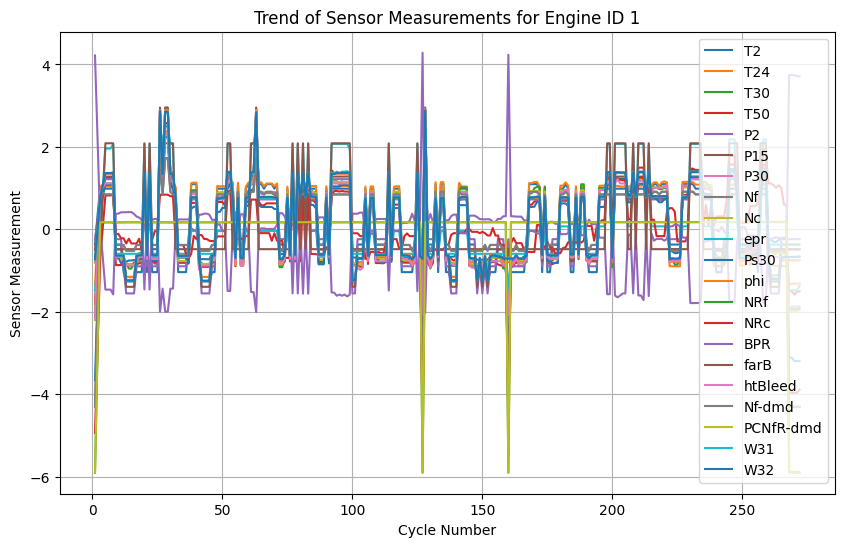

In [ ]:
engine_data = turbo4_train[turbo4_train['ENr'] == 12]

sensor_columns = engine_data.drop(columns=['ENr', 'C', 'OP-1', 'OP-2', 'OP-3', 'RUL'])
plt.figure(figsize=(10, 6))

for sensor in sensor_columns:
    plt.plot(engine_data['C'], engine_data[sensor], label=sensor)

plt.xlabel('Cycle Number')
plt.ylabel('Sensor Measurement')
plt.title('Trend of Sensor Measurements for Engine ID ' + str(1))

plt.legend()

plt.grid(True)


plt.show()

In [ ]:
engine_sensors = turbo1_train[turbo1_train['ENr'] == 1]
eng_sens = engine_sensors.drop(columns=['ENr', 'C', 'OP-1', 'OP-2', 'OP-3', 'RUL'])
engine_values = eng_sens.values

N = len(engine_sensors)
window_length = 12
g = N/window_length
Th = 10

centroids = []
for sensor_idx in range(engine_values.shape[1]):
    sensor_values = engine_values[:, sensor_idx]
    sensor_windows = [sensor_values[i:i+window_length] for i in range(0, len(sensor_values), window_length)]
    sensor_centroids = [np.mean(window) for window in sensor_windows]
    centroids.append(sensor_centroids)

initial_centroids = [centroid[0] for centroid in centroids]
iruls = []

squared_differences = [[(centroid - initial_centroids[i])**2  for centroid in centroids[i]] for i in range(len(centroids))]

sums_by_position = [sum(position_values) for position_values in zip(*squared_differences)]


for window_number, sum_value in enumerate(sums_by_position):
    if sum_value >= Th:
        RUL = N - window_length * window_number
        print(f'RUL: {RUL}')
        break


RUL: 72


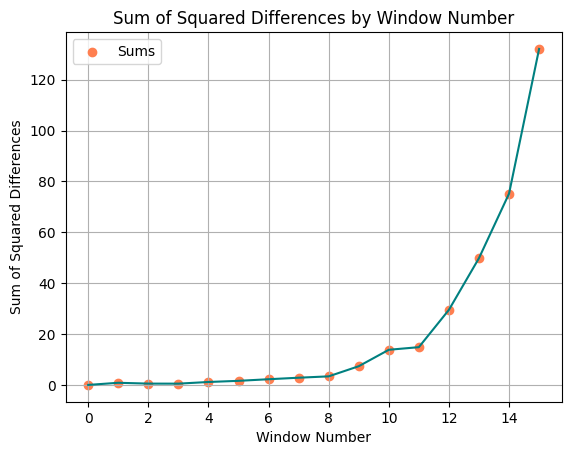

In [ ]:
window_numbers = list(range(len(sums_by_position)))

plt.scatter(window_numbers, sums_by_position, label='Sums', color='coral')
plt.plot(window_numbers, sums_by_position, linestyle='-', color='teal')
plt.xlabel('Window Number')
plt.ylabel('Sum of Squared Differences')
plt.title('Sum of Squared Differences by Window Number')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def degradation_model(turbo_train, nr_eng, window_length, Th):
    RULs = []
    for i in range(1, nr_eng):
      engine_sensors = turbo_train[turbo_train['ENr'] == i]
      eng_sens = engine_sensors.drop(columns=['ENr', 'C','OP-1', 'OP-2', 'OP-3', 'RUL'])
      engine_values = eng_sens.values

      N = len(engine_sensors)

      centroids = []
      for sensor_idx in range(engine_values.shape[1]):
          sensor_values = engine_values[:, sensor_idx]
          sensor_windows = [sensor_values[i:i+window_length] for i in range(0, len(sensor_values), window_length)]
          sensor_centroids = [np.mean(window) for window in sensor_windows]
          centroids.append(sensor_centroids)

      initial_centroids = [centroid[0] for centroid in centroids]
      iruls = []

      squared_differences = [[abs(centroid - initial_centroids[i]) for centroid in centroids[i]] for i in range(len(centroids))]

      sums_by_position = [sum(position_values) for position_values in zip(*squared_differences)]

      for window_number, sum_value in enumerate(sums_by_position):
          if sum_value >= Th:
              RUL = N-window_length * window_number
              RULs.append(RUL)
              break
    return np.min(RULs)

In [ ]:
initial_RUL1=degradation_model(turbo1_train, nr_train_1, 12, 6)
print(initial_RUL1)

56


In [ ]:
initial_RUL2=degradation_model(turbo2_train, nr_train_2, 12, 6)
initial_RUL3=degradation_model(turbo3_train, nr_train_3, 12, 6)
initial_RUL4=degradation_model(turbo4_train, nr_train_4, 12, 6)

In [ ]:
print("Minimum initial (w=12, th=2) RUL for FD001:", initial_RUL1)
print("Minimum initial (w=12, th=2) RUL for FD002:", initial_RUL2)
print("Minimum initial (w=12, th=2) RUL for FD003:", initial_RUL3)
print("Minimum initial (w=12, th=2) RUL for FD001:", initial_RUL4)

Minimum initial (w=12, th=2) RUL for FD001: 56
Minimum initial (w=12, th=2) RUL for FD002: 105
Minimum initial (w=12, th=2) RUL for FD003: 49
Minimum initial (w=12, th=2) RUL for FD001: 107


In [ ]:
def degradation_model(normalized_turbo, nr_eng, window_length, Th):
  RULs=[]
  RUL=0
  for i in range (1, nr_eng):
    engine_sensors = normalized_turbo[normalized_turbo['ENr'] == i]
    eng_sens = engine_sensors.drop(columns=['ENr', 'C', 'RUL'])
    engine_values=eng_sens.values

    N = len(engine_sensors)
    g=N/window_length
    centroids=[]
    mean_centroids=[]
    sq=[]
    iruls=[]


    windows = [engine_values[i:i+window_length] for i in range(0, len(engine_values), window_length)]

    for window in windows:
      centroid=window.mean()
      centroids.append(centroid)
      mean_centroid=centroid.mean()
      mean_centroids.append(mean_centroid)

    for i in range(len(windows)-1):
      squared=np.sqrt(np.sum((mean_centroids[i] - mean_centroids[0])**2))
      sq.append(squared)
      if squared>=Th:
        irul=N-window_length*i
        iruls.append(irul)
      else:
        i=i+1

    RUL=max(iruls)
    RULs.append(RUL)
  final_RUL=min(RULs)
  return final_RUL


In [ ]:
initial_RUL1=degradation_model(normalized_turbo1, nr_train_1, 12, 0.05)
initial_RUL2=degradation_model(normalized_turbo2, nr_train_2, 12, 0.05)
initial_RUL3=degradation_model(normalized_turbo3, nr_train_3, 12, 0.05)
initial_RUL4=degradation_model(normalized_turbo4, nr_train_4, 12, 0.05)

In [ ]:
print("Minimum initial (w=5, th=0.01) RUL for FD001:", initial_RUL1)
print("Minimum initial (w=5, th=0.01) RUL for FD002:", initial_RUL2)
print("Minimum initial (w=5, th=0.01) RUL for FD003:", initial_RUL3)
print("Minimum initial (w=5, th=0.01) RUL for FD001:", initial_RUL4)

Minimum initial (w=5, th=0.01) RUL for FD001: 101
Minimum initial (w=5, th=0.01) RUL for FD002: 105
Minimum initial (w=5, th=0.01) RUL for FD003: 68
Minimum initial (w=5, th=0.01) RUL for FD001: 107


133


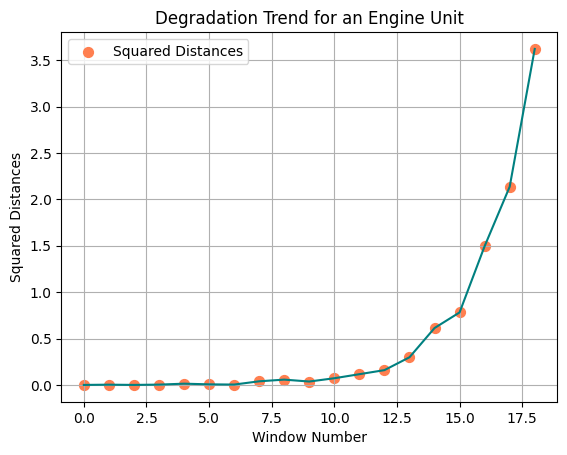

In [ ]:
engine_sensors = normalized_turbo3[normalized_turbo3['ENr'] == 19]
eng_sens = engine_sensors.drop(columns=['ENr', 'C', 'RUL'])
engine_values=eng_sens.values

N = len(engine_sensors)
window_length = 12
Th=0.05
g=N/window_length
centroids=[]
mean_centroids=[]
sq=[]
iruls=[]


windows = [engine_values[i:i+window_length] for i in range(0, len(engine_values), window_length)]

for window in windows:
  centroid=window.mean()
  centroids.append(centroid)
  mean_centroid=centroid.mean()
  mean_centroids.append(mean_centroid)

for i in range(len(windows)-1):
  s=np.sqrt(np.sum((mean_centroids[i] - mean_centroids[0])**2))
  squared=s**2
  sq.append(squared)
  if squared>=Th:
    irul=N-window_length*i
    iruls.append(irul)
  else:
    i=i+1

print(max(iruls))


plt.scatter(range(len(sq)), sq, color='coral', label='Squared Distances', s=50)
plt.xlabel('Window Number')
plt.ylabel('Squared Distances')
plt.title('Degradation Trend for an Engine Unit')
plt.legend()
plt.grid(True)


plt.plot(range(len(sq)), sq, color='teal', linestyle='-')

#RUL assignation

In [ ]:
def RUL_train(turbo_RUL_train, initial_RUL):
  turbo_RUL_train = turbo_RUL_train.copy()
  max_cycle = turbo_RUL_train.groupby('ENr')['C'].transform('max')
  turbo_RUL_train['RUL'] = initial_RUL
  turbo_RUL_train.loc[turbo_RUL_train['C'] > max_cycle - initial_RUL, 'RUL'] -= turbo_RUL_train['C'] - (max_cycle - initial_RUL)
  turbo_RUL_train.loc[turbo_RUL_train['RUL'] < 0, 'RUL'] = 0
  return turbo_RUL_train

In [ ]:
turbo1_train=RUL_train(turbo1_train, initial_RUL1)

In [ ]:
turbo1_train

,ENr,C,OP-1,OP-2,OP-3,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,-0.314711,-1.373690,0.0,-1.960981,0.051092,-0.860848,1.104758,-0.413888,-0.902209,-0.072214,0.157062,-1.062438,-0.196619,-0.509848,-0.755387,1.452095,1.253265,101
1,1,2,0.870755,-1.032895,0.0,-1.539943,0.278279,-0.692696,0.695026,-0.578089,-0.961536,-0.028486,0.650019,-0.653695,-0.426444,-0.307572,-0.755387,1.244488,1.279766,101
2,1,3,-1.956125,1.011877,0.0,-1.118905,0.051092,-0.524544,0.970419,-0.413888,-0.902209,-0.072214,1.142976,-0.898941,-0.544096,-0.509848,-0.755387,1.036882,1.253265,101
3,1,4,0.323617,-0.010509,0.0,-0.863730,-0.132158,-0.608620,1.037588,-0.249687,-0.810141,-0.509501,1.254289,-0.571947,-0.524756,-0.537805,-0.755387,0.863876,0.993444,101
4,1,5,-0.861849,-0.692099,0.0,-0.608555,-0.315408,-0.524544,0.970419,-0.413888,-0.718073,-0.903059,1.142976,-0.735444,-0.507350,-0.509848,-0.755387,0.690871,1.085044,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.177926,-1.032895,0.0,2.300438,2.217944,2.850416,-2.831357,2.377524,0.294396,3.032522,-2.943797,2.207505,0.022568,2.844975,3.320208,-2.630834,-2.687253,4
20627,100,197,-0.725065,-1.714485,0.0,2.300438,2.217944,2.890137,-2.831357,2.377524,0.294396,2.770150,-2.991502,2.207505,-0.128929,2.844975,1.689970,-3.253654,-2.048935,3
20628,100,198,0.186832,-0.010509,0.0,2.300438,2.267240,2.850416,-2.844791,2.377524,0.200929,2.638964,-2.991502,2.534499,-0.128929,2.844975,1.689970,-3.253654,-2.048935,2
20629,100,199,-0.497090,1.011877,0.0,2.121816,2.785913,2.850416,-3.489615,2.377524,0.200929,2.638964,-2.991502,2.534499,-0.153427,3.417268,1.689970,-3.807271,-2.837039,1


In [ ]:
turbo2_train=RUL_train(turbo2_train, initial_RUL2)
turbo3_train=RUL_train(turbo3_train, initial_RUL3)
turbo4_train=RUL_train(turbo4_train, initial_RUL4)

In [ ]:
def RUL_test(turbo_RUL_test, initial_RUL, nr_train, y_RUL):
    turbo_RUL_test = turbo_RUL_test.copy()
    y_RUL_series = y_RUL[0]
    adjusted_engine_numbers = turbo_RUL_test['ENr'].values - nr_train-1
    max_cycle = turbo_RUL_test.groupby('ENr')['C'].transform('max')+ y_RUL_series.iloc[adjusted_engine_numbers].values
    turbo_RUL_test['RUL'] = initial_RUL
    turbo_RUL_test.loc[turbo_RUL_test['C'] > max_cycle - initial_RUL, 'RUL'] -= turbo_RUL_test['C'] - (max_cycle - initial_RUL)
    turbo_RUL_test.loc[turbo_RUL_test['RUL'] < 0, 'RUL'] = 0
    return turbo_RUL_test

In [ ]:
turbo1_test=RUL_test(turbo1_test, initial_RUL1, nr_train_1, y_RUL_1)

In [ ]:
turbo1_test

,ENr,C,OP-1,OP-2,OP-3,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
20631,101,1,1.053135,1.011877,0.0,1.101116,-0.894093,-1.177292,0.486801,-0.742289,-0.679455,-1.252889,0.252473,-0.898941,-1.039202,-0.980181,-0.755387,0.068051,0.729015,101
20632,101,2,-1.226608,-1.032895,0.0,-0.570279,-0.555455,-1.361995,1.124908,-0.988590,-0.560522,-0.596959,0.602314,-0.653695,-0.585677,-1.389666,-0.347828,0.621669,0.833289,101
20633,101,3,0.141238,0.330287,0.0,-0.327863,-0.540452,-1.177292,0.768912,-0.742289,-0.441589,0.058972,0.650019,-0.898941,-0.745878,-0.980181,0.059732,1.175286,0.937563,101
20634,101,4,1.919437,-0.010509,0.0,-0.353380,-0.717272,-0.970081,0.742044,-0.824390,-0.560522,-0.422044,0.451246,-0.735444,-0.655624,-1.202191,-0.347828,1.106084,0.834441,101
20635,101,5,0.642781,-0.010509,0.0,-0.327863,-0.540452,-0.762870,0.768912,-0.906490,-0.679455,-0.771873,0.650019,-0.898941,-0.745878,-1.049251,-0.755387,1.036882,0.937563,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,2.238601,-0.010509,0.0,1.177669,1.868590,1.150357,-0.399832,-0.578089,4.341474,0.408801,-0.526717,-0.244952,4.420501,1.200454,1.689970,-0.762375,-0.948586,24
33723,200,195,-0.497090,-0.351304,0.0,1.305256,1.334915,1.150357,-0.426700,-0.578089,4.386248,0.496258,-0.812950,-0.244952,4.459826,0.532779,1.689970,-1.385195,-0.948586,23
33724,200,196,-0.269116,-1.032895,0.0,1.611466,1.334915,1.150357,-0.480435,-0.578089,4.455649,0.408801,-0.812950,-0.571947,4.616481,0.532779,1.689970,-1.523599,-1.099524,22
33725,200,197,-1.728151,0.330287,0.0,1.662501,1.315625,1.150357,-0.426700,-0.249687,4.480835,0.496258,-0.606226,-0.571947,4.635176,0.720254,1.689970,-1.523599,-0.464663,21


In [ ]:
turbo2_test=RUL_test(turbo2_test, initial_RUL2, nr_train_2, y_RUL_2)
turbo3_test=RUL_test(turbo3_test, initial_RUL3, nr_train_3, y_RUL_3)
turbo4_test=RUL_test(turbo4_test, initial_RUL4, nr_train_4, y_RUL_4)

In [ ]:
turbo3_test

,ENr,C,OP-1,OP-2,OP-3,T24,T30,T50,P15,P30,...,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
24720,101,1,-0.764363,-1.364282,0.0,-1.053262,-0.938927,-0.708384,-0.878436,-0.107599,...,-0.715790,-1.050589,-0.322587,-0.781347,-0.586234,-0.397811,-0.879422,0.388476,0.427943,68
24721,101,2,0.282692,-0.684317,0.0,-0.956199,-0.665557,-0.587563,-0.878436,-0.186429,...,-0.779145,-1.070057,-0.329814,-0.535070,-0.442948,-0.094346,-0.879422,0.313518,0.568407,68
24722,101,3,0.646886,-1.024300,0.0,-1.053262,-0.938927,-0.708384,-0.878436,-0.159010,...,-0.715790,-1.050589,-0.322587,-0.781347,-0.299662,-0.397811,-0.879422,0.388476,0.427943,68
24723,101,4,1.238700,0.335629,0.0,-0.956199,-0.696346,-0.805899,-0.878436,-0.133305,...,-0.528414,-0.933783,-0.284647,-0.710982,-0.313050,-0.449059,-0.879422,0.313518,0.558048,68
24724,101,5,-0.035977,0.335629,0.0,-0.859136,-0.453766,-0.839631,-0.878436,-0.159010,...,-0.715790,-1.050589,-0.315360,-0.640617,-0.326437,-0.397811,-0.879422,0.388476,0.427943,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41311,200,243,0.510313,-1.024300,0.0,1.324782,1.221905,1.051798,-0.878436,2.116761,...,1.509410,0.974040,2.047742,1.259234,1.623119,-2.043760,1.896459,1.737718,1.021287,32
41312,200,244,-1.083032,0.675611,0.0,0.499746,1.221905,1.051798,-0.878436,2.116761,...,1.509410,0.974040,2.148915,1.329599,1.591278,-2.043760,1.202489,1.937606,1.504415,31
41313,200,245,-2.403233,0.675611,0.0,0.790935,1.277885,1.225977,-0.878436,2.130471,...,1.477732,0.974040,2.329580,1.470329,1.567397,-2.043760,1.202489,2.037550,1.268237,30
41314,200,246,-0.263597,0.335629,0.0,0.499746,1.285349,1.225977,-0.878436,2.154462,...,1.477732,0.974040,2.344033,1.470329,1.567397,-2.043760,1.202489,2.037550,1.706615,29


#Preparing for training

In [ ]:
def train_split(turbo_train, turbo_test):
  X_train=turbo_train.iloc[:, :-1]
  y_train=turbo_train.iloc[:, -1]

  X_test=turbo_test.iloc[:, :-1]
  y_test=turbo_test.iloc[:, -1]
  return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test=train_split(turbo1_train, turbo1_test)
y_test

20631    101
20632    101
20633    101
20634    101
20635    101
        ... 
33722     24
33723     23
33724     22
33725     21
33726     20
Name: RUL, Length: 13096, dtype: int64

In [ ]:
X2_train, y2_train, X2_test, y2_test=train_split(turbo2_train, turbo2_test)
X3_train, y3_train, X3_test, y3_test=train_split(turbo3_train, turbo3_test)
X4_train, y4_train, X4_test, y4_test=train_split(turbo4_train, turbo4_test)

#Neural Network Construction

In [ ]:
def PHME_score(y_true, y_pred):
    dif=y_pred-y_true
    if dif>=0:
      score= math.exp(-dif /13)-1
    else:
      score= math.exp(-dif /10)-1
    return score

In [ ]:
print("Score for an overestimation: ", PHME_score(112, 192))
print("Score for an underestimation: ", PHME_score(192, 112))

Score for an overestimation:  -0.9978747081690988
Score for an underestimation:  2979.9579870417283


In [ ]:
def RMSE(y_true, y_pred):
    squared_errors = tf.square(y_true - y_pred)
    individual_rmse = tf.sqrt(tf.reduce_mean(squared_errors, axis=-1))
    return tf.keras.backend.mean(individual_rmse)

def PHME_score(y_true, y_pred):
    dif = y_pred - y_true
    positive_score = tf.exp(-dif / 13) - 1
    negative_score = tf.exp(-dif / 10) - 1
    individual_score = tf.where(dif >= 0, positive_score, negative_score)
    return tf.keras.backend.mean(individual_score)

def MAE(y_true, y_pred):
    absolute_errors = tf.abs(y_true - y_pred)
    individual_mae = tf.reduce_mean(absolute_errors, axis=-1)
    return tf.keras.backend.mean(individual_mae)

#With my initial RUL

##FD001

In [ ]:
model = Sequential([
    LSTM(units=60, input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.1),
    LSTM(units=60, return_sequences=True),
    Dropout(0.1),
    LSTM(units=60, return_sequences=True),
    Dropout(0.1),
    LSTM(units=60, return_sequences=True),
    Dropout(0.1),
    Dense(units=60),
    Dropout(0.1),
    Dense(units=60),
    Dropout(0.1),
    Dense(units=60),
    Dense(units=1)
])
learning_rate = 0.002
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=[RMSE, PHME_score, MAE])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 19, 60)            14880     
                                                                 
 dropout_6 (Dropout)         (None, 19, 60)            0         
                                                                 
 lstm_5 (LSTM)               (None, 19, 60)            29040     
                                                                 
 dropout_7 (Dropout)         (None, 19, 60)            0         
                                                                 
 lstm_6 (LSTM)               (None, 19, 60)            29040     
                                                                 
 dropout_8 (Dropout)         (None, 19, 60)            0         
                                                                 
 lstm_7 (LSTM)               (None, 19, 60)           

In [ ]:
history = model.fit(X_train, y_train, batch_size=15, epochs=20, validation_split=0.2, verbose=1)

Epoch 1/20
1101/1101 [==============================] - 20s 13ms/step - loss: 1239.4565 - RMSE: 31.0537 - PHME_score: 145.4853 - MAE: 29.9222 - val_loss: 1219.3307 - val_RMSE: 32.5509 - val_PHME_score: 22.4890 - val_MAE: 32.5485
Epoch 2/20
1101/1101 [==============================] - 12s 11ms/step - loss: 513.3373 - RMSE: 19.6631 - PHME_score: 6.9017 - MAE: 16.9252 - val_loss: 369.2520 - val_RMSE: 15.9994 - val_PHME_score: 8.2448 - val_MAE: 12.7177
Epoch 3/20
1101/1101 [==============================] - 13s 12ms/step - loss: 320.8996 - RMSE: 16.0604 - PHME_score: 5.9023 - MAE: 13.0482 - val_loss: 379.7217 - val_RMSE: 16.0903 - val_PHME_score: 9.9644 - val_MAE: 13.0511
Epoch 4/20
1101/1101 [==============================] - 13s 11ms/step - loss: 310.4132 - RMSE: 15.7425 - PHME_score: 5.3905 - MAE: 12.7605 - val_loss: 367.7521 - val_RMSE: 15.7278 - val_PHME_score: 8.7392 - val_MAE: 12.5466
Epoch 5/20
1101/1101 [==============================] - 13s 11ms/step - loss: 301.8560 - RMSE: 15.5

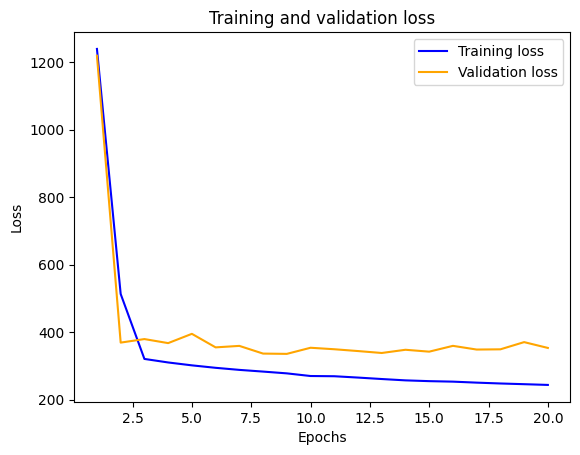

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y_pred = model.predict(X_test,verbose=1, batch_size=200)
y_true = y_test

66/66 [==============================] - 0s 6ms/step - loss: 195.9108 - RMSE: 11.6140 - PHME_score: 3.8870 - MAE: 9.9106

RMSE: 11.613950729370117

PHME: 3.8870317935943604

MAE: 9.91060733795166
66/66 [==============================] - 2s 5ms/step


##FD002

In [ ]:
model = Sequential([
    LSTM(units=60, input_shape=(X2_train.shape[1], 1), return_sequences=True),
    Dropout(0.1),
    LSTM(units=60, return_sequences=True),
    Dropout(0.1),
    LSTM(units=60, return_sequences=True),
    Dropout(0.1),
    LSTM(units=60, return_sequences=True),
    Dropout(0.1),
    Dense(units=60),
    Dropout(0.1),
    Dense(units=60),
    Dropout(0.1),
    Dense(units=60),
    Dense(units=1)
])
learning_rate = 0.002
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=[RMSE, PHME_score, MAE])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 26, 60)            14880     
                                                                 
 dropout_12 (Dropout)        (None, 26, 60)            0         
                                                                 
 lstm_9 (LSTM)               (None, 26, 60)            29040     
                                                                 
 dropout_13 (Dropout)        (None, 26, 60)            0         
                                                                 
 lstm_10 (LSTM)              (None, 26, 60)            29040     
                                                                 
 dropout_14 (Dropout)        (None, 26, 60)            0         
                                                                 
 lstm_11 (LSTM)              (None, 26, 60)           

In [ ]:
history = model.fit(X2_train, y2_train, batch_size=15, epochs=60, validation_split=0.2, verbose=1)

Epoch 1/60
2868/2868 [==============================] - 42s 12ms/step - loss: 823.6187 - RMSE: 23.9074 - PHME_score: 93.1358 - MAE: 22.2668 - val_loss: 664.5410 - val_RMSE: 19.3973 - val_PHME_score: 18.4184 - val_MAE: 18.2019
Epoch 2/60
2868/2868 [==============================] - 34s 12ms/step - loss: 604.2012 - RMSE: 20.1286 - PHME_score: 20.9556 - MAE: 18.5485 - val_loss: 619.7604 - val_RMSE: 19.5935 - val_PHME_score: 22.1970 - val_MAE: 18.6282
Epoch 3/60
2868/2868 [==============================] - 35s 12ms/step - loss: 591.0490 - RMSE: 19.8070 - PHME_score: 20.3890 - MAE: 18.2938 - val_loss: 666.4026 - val_RMSE: 19.2341 - val_PHME_score: 7.1348 - val_MAE: 18.0626
Epoch 4/60
2868/2868 [==============================] - 34s 12ms/step - loss: 578.0004 - RMSE: 19.5023 - PHME_score: 19.8939 - MAE: 18.0075 - val_loss: 593.5537 - val_RMSE: 18.7646 - val_PHME_score: 26.8278 - val_MAE: 17.2908
Epoch 5/60
2868/2868 [==============================] - 34s 12ms/step - loss: 549.5520 - RMSE: 19

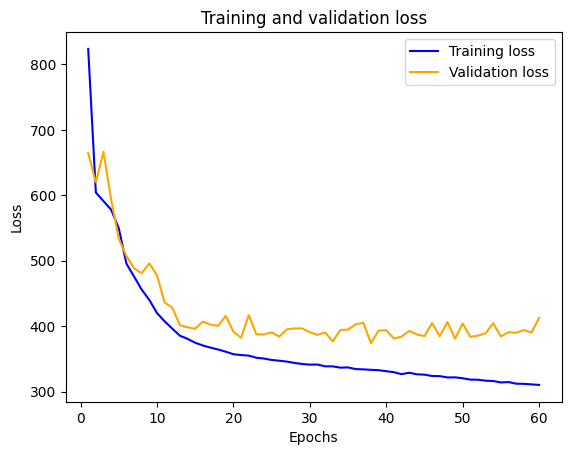

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(X2_test, y2_test, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y2_pred = model.predict(X2_test,verbose=1, batch_size=200)
y_2true = y2_test

170/170 [==============================] - 1s 6ms/step - loss: 339.0751 - RMSE: 13.6408 - PHME_score: 31.4863 - MAE: 10.7512

RMSE: 13.640830039978027

PHME: 31.486299514770508

MAE: 10.751214981079102
170/170 [==============================] - 3s 6ms/step


##FD003

In [ ]:
model = Sequential([
    LSTM(units=90, input_shape=(X3_train.shape[1], 1), return_sequences=True),
    Dropout(0.1),
    LSTM(units=90, return_sequences=True),
    Dropout(0.1),
    LSTM(units=90, return_sequences=True),
    Dropout(0.1),
    LSTM(units=90, return_sequences=True),
    Dropout(0.1),
    LSTM(units=90, return_sequences=True),
    Dropout(0.1),
    LSTM(units=90, return_sequences=True),
    Dropout(0.1),
    Dense(units=90),
    Dropout(0.1),
    Dense(units=90),
    Dropout(0.1),
    Dense(units=90),
    Dense(units=1)
])
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=[RMSE, PHME_score, MAE])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 20, 90)            33120     
                                                                 
 dropout_38 (Dropout)        (None, 20, 90)            0         
                                                                 
 lstm_27 (LSTM)              (None, 20, 90)            65160     
                                                                 
 dropout_39 (Dropout)        (None, 20, 90)            0         
                                                                 
 lstm_28 (LSTM)              (None, 20, 90)            65160     
                                                                 
 dropout_40 (Dropout)        (None, 20, 90)            0         
                                                                 
 lstm_29 (LSTM)              (None, 20, 90)           

In [ ]:
history = model.fit(X3_train, y3_train, batch_size=20, epochs=60, validation_split=0.2, verbose=1)

Epoch 1/60
989/989 [==============================] - 26s 17ms/step - loss: 418.9856 - RMSE: 16.1949 - PHME_score: 7.8888 - MAE: 15.2401 - val_loss: 347.4103 - val_RMSE: 15.0341 - val_PHME_score: 1.2917 - val_MAE: 15.0322
Epoch 2/60
989/989 [==============================] - 15s 15ms/step - loss: 368.6738 - RMSE: 15.1339 - PHME_score: 1.3454 - MAE: 14.4802 - val_loss: 349.2894 - val_RMSE: 15.3250 - val_PHME_score: 1.4201 - val_MAE: 15.3240
Epoch 3/60
989/989 [==============================] - 16s 16ms/step - loss: 366.1058 - RMSE: 15.0114 - PHME_score: 1.3190 - MAE: 14.4354 - val_loss: 347.3281 - val_RMSE: 15.0209 - val_PHME_score: 1.2863 - val_MAE: 15.0201
Epoch 4/60
989/989 [==============================] - 16s 16ms/step - loss: 364.5674 - RMSE: 14.9330 - PHME_score: 1.2808 - MAE: 14.4103 - val_loss: 346.8065 - val_RMSE: 13.6430 - val_PHME_score: 0.7546 - val_MAE: 13.6426
Epoch 5/60
989/989 [==============================] - 16s 16ms/step - loss: 361.7356 - RMSE: 14.8367 - PHME_scor

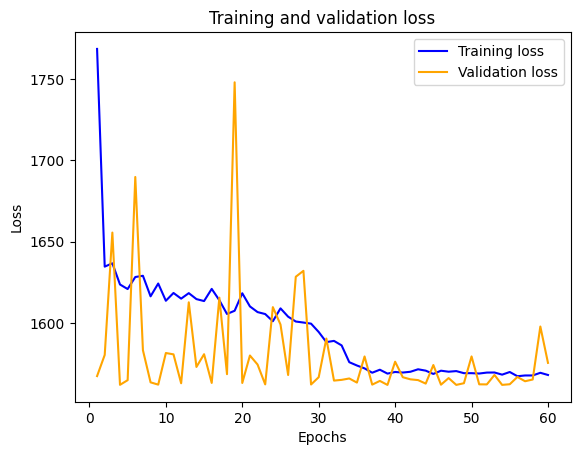

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(X3_test, y3_test, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y3_pred = model.predict(X3_test,verbose=1, batch_size=200)
y_3true = y3_test

83/83 [==============================] - 1s 8ms/step - loss: 1064.5801 - RMSE: 30.9085 - PHME_score: 21.7104 - MAE: 30.9084

RMSE: 30.9084529876709

PHME: 21.710416793823242

MAE: 30.90839958190918
83/83 [==============================] - 2s 8ms/step


#FD004

In [ ]:
model = Sequential([
    LSTM(units=30, input_shape=(X4_train.shape[1], 1), return_sequences=True),
    Dropout(0.1),
    LSTM(units=30, return_sequences=True),
    Dropout(0.1),
    Dense(units=30),
    Dropout(0.1),
    Dense(units=30),
    Dropout(0.1),
    Dense(units=30),
    Dense(units=1)
])
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=[RMSE, PHME_score, MAE])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 26, 30)            3840      
                                                                 
 dropout_34 (Dropout)        (None, 26, 30)            0         
                                                                 
 lstm_25 (LSTM)              (None, 26, 30)            7320      
                                                                 
 dropout_35 (Dropout)        (None, 26, 30)            0         
                                                                 
 dense_20 (Dense)            (None, 26, 30)            930       
                                                                 
 dropout_36 (Dropout)        (None, 26, 30)            0         
                                                                 
 dense_21 (Dense)            (None, 26, 30)           

In [ ]:
history = model.fit(X4_train, y4_train, batch_size=10, epochs=40, validation_split=0.2, verbose=1)

Epoch 1/40
4900/4900 [==============================] - 45s 8ms/step - loss: 1004.9385 - RMSE: 27.0984 - PHME_score: 156.5715 - MAE: 25.1968 - val_loss: 706.5699 - val_RMSE: 20.8731 - val_PHME_score: 8.3165 - val_MAE: 20.0679
Epoch 2/40
4900/4900 [==============================] - 41s 8ms/step - loss: 791.1541 - RMSE: 23.7892 - PHME_score: 15.4934 - MAE: 22.0500 - val_loss: 694.4199 - val_RMSE: 20.9178 - val_PHME_score: 10.0938 - val_MAE: 19.7108
Epoch 3/40
4900/4900 [==============================] - 41s 8ms/step - loss: 725.1266 - RMSE: 22.6952 - PHME_score: 14.1532 - MAE: 20.7706 - val_loss: 641.1638 - val_RMSE: 20.7261 - val_PHME_score: 8.8973 - val_MAE: 19.4029
Epoch 4/40
4900/4900 [==============================] - 41s 8ms/step - loss: 670.1706 - RMSE: 21.7626 - PHME_score: 14.3578 - MAE: 19.6372 - val_loss: 591.5757 - val_RMSE: 19.6331 - val_PHME_score: 6.9761 - val_MAE: 18.0657
Epoch 5/40
4900/4900 [==============================] - 41s 8ms/step - loss: 600.8138 - RMSE: 20.6006

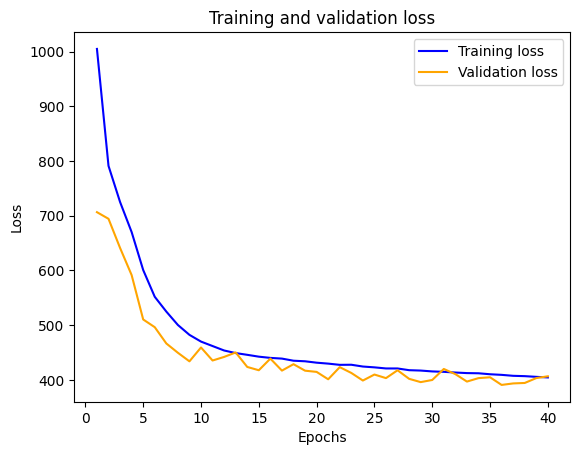

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(X4_test, y4_test, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y4_pred = model.predict(X4_test,verbose=1, batch_size=200)
y_4true = y4_test

207/207 [==============================] - 2s 5ms/step - loss: 281.9121 - RMSE: 13.8698 - PHME_score: 8.4528 - MAE: 11.8860

RMSE: 13.869757652282715

PHME: 8.45277214050293

MAE: 11.886040687561035
207/207 [==============================] - 1s 4ms/step
